<h4>A dataset for country level analysis</h4>

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce

<h5>Country level GDL data:</h5>
<p>The data for country level variables is downloaded instead of aggregated from regional level.</p>

,iso_code,year,iwipov70,iwipov50,iwipov35,iwi,regpopm,hhsize,ln_pop,hhpov35,...,ln_hhpov70,poppov35,poppov50,poppov70,ln_poppov35,ln_poppov50,ln_poppov70,steel,exports,ln_steel
868,AFG,1998,NaN,NaN,NaN,NaN,NaN,9.540833,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,NaN,11.649098
869,ALB,1998,NaN,NaN,NaN,NaN,NaN,4.494118,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,NaN,11.649098
870,DZA,1998,NaN,NaN,NaN,NaN,NaN,6.865000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,NaN,11.649098
871,AGO,1998,0.977,0.912,0.804,20.5,15.0,6.276818,2.70805,1.921356,...,0.847918,12.06,13.68,14.655,2.489894,2.615935,2.684782,114588.0,NaN,11.649098
872,ARG,1998,NaN,NaN,NaN,NaN,NaN,4.320000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,NaN,11.649098


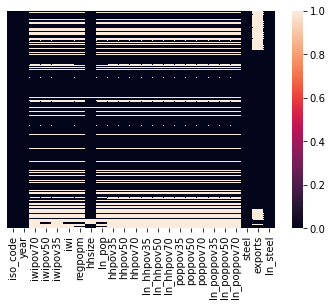

In [2]:
import glob
filenames = glob.glob('gdl_iso' + "\*.csv")
filetitle = ["iwipov70", "iwipov50", "iwipov35", "iwi", "regpopm"]
files_dict = dict(zip(filenames, filetitle))
li = []
for filename in files_dict:
    df = pd.melt(pd.read_csv(filename, skipinitialspace=True),id_vars=['Country', 'ISO_Code', 'Level', 'GDLCODE', 'Region'],var_name='year', value_name=files_dict.get(filename))
    li.append(df)
    pass
gdl_iso = reduce(lambda df1, df2: df1.merge(df2, "outer"), li)

gdl_iso['year'] = gdl_iso['year'].apply(int)

# merge mean household size by region
hhsize = pd.melt(pd.read_csv("GDL-Average-household-size-data-national.csv", skipinitialspace=True), id_vars=['Country', 'ISO_Code', 'Level', 'GDLCODE', 'Region'],var_name='year', value_name='hhsize')
hhsize = hhsize.pivot_table(index='ISO_Code', values='hhsize', aggfunc='mean').reset_index()
gdl_iso = pd.merge(gdl_iso, hhsize, on='ISO_Code', how='left')

# drop unnecessary columns
gdl_iso = gdl_iso.drop(columns=['Country', 'Region', 'Level', 'GDLCODE']).reset_index()
gdl_iso.drop('index', axis=1, inplace=True)

# add log of population
gdl_iso['ln_pop'] = np.where(gdl_iso['regpopm'] > 0, np.log(gdl_iso['regpopm']), np.nan)

# change % variable decimal format
gdl_iso['iwipov35'] = gdl_iso['iwipov35'] / 100
gdl_iso['iwipov50'] = gdl_iso['iwipov50'] / 100
gdl_iso['iwipov70'] = gdl_iso['iwipov70'] / 100

# generate useable continuous dependent variables
gdl1 = gdl_iso.dropna(subset=['iwipov35', 'iwipov50', 'iwipov70', 'regpopm', 'hhsize']).copy()
gdl1 = gdl1[gdl1.iwipov35 != 0]
gdl1 = gdl1[gdl1.iwipov50 != 0]
gdl1 = gdl1[gdl1.iwipov70 != 0]
# generate continuous dependant variable: number of households below poverty levels of IWI 35, 50 & 70
gdl1['hhpov35'] = (gdl1.regpopm / gdl1.hhsize) * gdl1.iwipov35
gdl1['hhpov50'] = (gdl1.regpopm / gdl1.hhsize) * gdl1.iwipov50
gdl1['hhpov70'] = (gdl1.regpopm / gdl1.hhsize) * gdl1.iwipov70
gdl1['ln_hhpov35'] = np.log(gdl1.hhpov35)
gdl1['ln_hhpov50'] = np.log(gdl1.hhpov50)
gdl1['ln_hhpov70'] = np.log(gdl1.hhpov70)
# generate continuous dependant variable: population below poverty levels of IWI 35, 50 & 70
gdl1['poppov35'] = gdl1.hhpov35 * gdl1.hhsize
gdl1['poppov50'] = gdl1.hhpov50 * gdl1.hhsize
gdl1['poppov70'] = gdl1.hhpov70 * gdl1.hhsize
gdl1['ln_poppov35'] = np.log(gdl1.poppov35)
gdl1['ln_poppov50'] = np.log(gdl1.poppov50)
gdl1['ln_poppov70'] = np.log(gdl1.poppov70)
# merge to gdl data 
gdl1.drop(columns=['iwipov35', 'iwipov50', 'iwipov70', 'iwi', 'regpopm', 'ln_pop', 'hhsize'], inplace=True)
gdl_iso = pd.merge(gdl_iso, gdl1, on=['ISO_Code', 'year'], how='left')

# add steel figures
cnsteel = pd.read_csv("cn_steel_1998-2018.csv", thousands=',')
# merge to gdl
gdl_iso_steel = pd.merge(gdl_iso, cnsteel, how="left", on='year')
# generate log steel variable
gdl_iso_steel['ln_steel'] = np.log(gdl_iso_steel.steel)

gdl_iso_steel.rename(columns={'ISO_Code':'iso_code'}, inplace=True)

# time frame reduced to 1998 to 2018
gdl_iso_steel = gdl_iso_steel[(gdl_iso_steel.year > 1997) & (gdl_iso_steel.year < 2019)]

display(gdl_iso_steel.head())
# heatmap shows us where we have missing values
display(sns.heatmap(gdl_iso_steel.isna(), yticklabels=False))

<h5>Country level counts, dummies, probabilities & amounts:</h5>

<p>The following dataframes are created for the country level dataset:</p>
    <li>Country level project counts & dummies</li>
    <li>Country level probabilities of receiving a development project</li> 
    <li>Country level project values</li>

In [3]:
cnfin = pd.read_csv("cnfin.csv", index_col=0)
projects_iso = cnfin[['iso_code', 'year']].copy()
# the dummay variable for all projects equal to 1 for each row in cnfin (0s assigned later)
projects_iso['total'] = 1
# generate dataframe with dummies per sector and flow class
crs_sector = pd.get_dummies(cnfin['crs_sector_name'])
flow_class = pd.get_dummies(cnfin['flow_class'])
# merge all dummmy dataframes
projects_iso = pd.concat([projects_iso, crs_sector, flow_class], axis=1)
# give short variable names
shortname = ['iso_code', 'year', 'total', 'debt', 'agri', 'bank', 'business', 'comms', 'food_aid', 'educ', 'emergency', 
             'energy', 'budget', 'environment', 'civil', 'health', 'industry', 'commod', 
             'multisector', 'social_infra', 'pop_policy', 'ngo_support', 'trade_tourism', 
             'transport', 'unspecified', 'water', 'women', 'oda', 'oof', 'vague']
rename_cols = dict(zip(projects_iso.columns,shortname))
projects_iso.columns = projects_iso.columns.map(rename_cols)
# aggregate dummies to get project counts by each region (GDLCODE) year combination
projects_iso = projects_iso.pivot_table(index = shortname[:2], values = shortname[2:], aggfunc = 'sum').reset_index()
# generate binary variables if count is > 0 = 1 else 0
for column in projects_iso.columns[2:]:
    projects_iso[column+'_d'] = np.where(projects_iso[column]>=1, 1, 0)
    pass
dummies = list(projects_iso.columns[2:30])
# change the order so that total is first column (as it has the greatest number of observations so;
# sectors and flow class probabilities with lower observations can be merged using 'append' 
dummies[21], dummies[0] = dummies[0], dummies[21]
pivot = []
for i in dummies:
    p1 = projects_iso.pivot_table(index = ['iso_code', 'year'], values = i, aggfunc = 'sum').reset_index()
    p1 = p1[(p1[i] > 0)]
    p = p1.pivot_table(index = 'iso_code', values = 'year', aggfunc = pd.Series.nunique).reset_index()
    p['year'] = p['year'] / 15
    p.rename(columns = {'year':i+'_p'}, inplace = True) 
    pivot.append(p)
    pass
p_data_iso = reduce(lambda p1, p2: p1.merge(p2, "left"), pivot)
display(projects_iso.head())
display(p_data_iso.head())

,iso_code,year,agri,bank,budget,business,civil,commod,comms,debt,...,oof_d,pop_policy_d,social_infra_d,total_d,trade_tourism_d,transport_d,unspecified_d,vague_d,water_d,women_d
0,AFG,2001,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,AFG,2002,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,AFG,2003,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,AFG,2006,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,AFG,2008,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


,iso_code,total_p,bank_p,budget_p,business_p,civil_p,commod_p,comms_p,debt_p,educ_p,...,oof_p,pop_policy_p,social_infra_p,agri_p,trade_tourism_p,transport_p,unspecified_p,vague_p,water_p,women_p
0,AFG,0.600000,NaN,0.066667,NaN,0.200000,NaN,0.066667,NaN,0.266667,...,0.133333,NaN,0.066667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AGO,0.800000,NaN,NaN,NaN,0.200000,NaN,0.133333,NaN,0.200000,...,0.400000,NaN,0.066667,0.133333,NaN,0.333333,NaN,0.2,0.266667,NaN
2,ALB,0.600000,NaN,NaN,NaN,0.133333,NaN,0.066667,NaN,0.266667,...,0.466667,NaN,NaN,0.066667,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.200000,NaN,NaN,NaN,NaN,0.200000,NaN,NaN,NaN,NaN
4,BDI,0.666667,NaN,NaN,NaN,NaN,NaN,0.133333,NaN,0.333333,...,0.133333,NaN,NaN,NaN,NaN,0.066667,NaN,NaN,NaN,0.066667


In [4]:
# use dataset regions and aggregate amounts
amounts = pd.read_csv("data.csv", index_col=0)
amounts = amounts[['ISO_Code', 'year', 'amount_total', 'amount_oof', 'amount_oda', 'amount_transport']]
amounts = amounts.pivot_table(index = ['ISO_Code', 'year'], values = ['amount_total', 'amount_oof', 'amount_oda', 'amount_transport'], aggfunc = 'sum').reset_index()
amounts.rename(columns={'ISO_Code':'iso_code'}, inplace=True)
amounts.head()

,iso_code,year,amount_oda,amount_oof,amount_total,amount_transport
0,AFG,1998,0.00,0.0,0.00,0.0
1,AFG,1999,0.00,0.0,0.00,0.0
2,AFG,2000,0.00,0.0,0.00,0.0
3,AFG,2001,2.27,0.0,2.27,0.0
4,AFG,2002,8.41,0.0,8.41,0.0


<h5>Merging to final country level dataset:</h5>

,iso_code,year,iwipov70,iwipov50,iwipov35,iwi,regpopm,hhsize,ln_pop,hhpov35,...,oof_p,pop_policy_p,social_infra_p,agri_p,trade_tourism_p,transport_p,unspecified_p,vague_p,water_p,women_p
0,AFG,1998,NaN,NaN,NaN,NaN,NaN,9.540833,NaN,NaN,...,0.133333,0.0,0.066667,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,ALB,1998,NaN,NaN,NaN,NaN,NaN,4.494118,NaN,NaN,...,0.466667,0.0,0.000000,0.066667,0.0,0.000000,0.0,0.0,0.000000,0.0
2,DZA,1998,NaN,NaN,NaN,NaN,NaN,6.865000,NaN,NaN,...,0.066667,0.0,0.066667,0.066667,0.0,0.000000,0.0,0.0,0.000000,0.0
3,AGO,1998,0.977,0.912,0.804,20.5,15.0,6.276818,2.70805,1.921356,...,0.400000,0.0,0.066667,0.133333,0.0,0.333333,0.0,0.2,0.266667,0.0
4,ARG,1998,NaN,NaN,NaN,NaN,NaN,4.320000,NaN,NaN,...,0.200000,0.0,0.000000,0.000000,0.0,0.200000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704,QAT,2016,NaN,NaN,NaN,NaN,NaN,6.440000,NaN,NaN,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2705,CUB,2017,NaN,NaN,NaN,NaN,NaN,3.840000,NaN,NaN,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2706,QAT,2017,NaN,NaN,NaN,NaN,NaN,6.440000,NaN,NaN,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2707,CUB,2018,NaN,NaN,NaN,NaN,NaN,3.840000,NaN,NaN,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


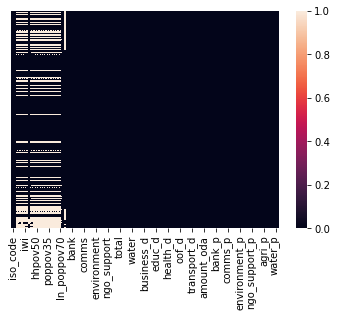

In [10]:
# merge by country - year
dfs = [gdl_iso_steel, projects_iso, amounts]
data_iso = reduce(lambda  left,right: pd.merge(left,right,on=['iso_code', 'year'], how='left'), dfs)
# merge probabilities by country
data_iso = pd.merge(data_iso, p_data_iso, how="left", on='iso_code')
# fill NA values for counts, dummies, probabilities & amounts
fill_nan = data_iso.columns[24:]
for column in fill_nan:
    data_iso.fillna({column:0}, inplace=True)
    pass

display(data_iso)
display(sns.heatmap(data_iso.isna(), yticklabels=False))

<h4>Exports:</h4>
<p>Final dataset is exported in .dta for analysis in Stata. Analysis can be run using analysis.do found in the repository.</p>

In [22]:
data_iso.to_stata('data_iso.dta')

<h5>Dataframe: visuals to support reduced form relationship</h5>

In [21]:
freq = p_data_iso[['iso_code', 'total_p']]
regular = freq[freq['total_p'] > p_data_iso['total_p'].median()]
irregular = freq[freq['total_p'] < p_data_iso['total_p'].median()]

reg = list(regular['iso_code'])
irreg = list(irregular['iso_code'])

reg_iwi = gdl_iso[gdl_iso['ISO_Code'].isin(reg)]
reg_iwi = reg_iwi.dropna(subset=['ISO_Code', 'year', 'iwipov50'])
reg_iwi = reg_iwi.pivot_table(index='year', values='iwipov50', aggfunc='mean').reset_index()
reg_iwi.rename(columns={'iwipov50':'reg_iwipov50'}, inplace=True)

irreg_iwi = gdl_iso[gdl_iso['ISO_Code'].isin(irreg)]
irreg_iwi = irreg_iwi.dropna(subset=['ISO_Code', 'year', 'iwipov50'])
irreg_iwi = irreg_iwi.pivot_table(index='year', values='iwipov50', aggfunc='mean').reset_index()
irreg_iwi.rename(columns={'iwipov50':'irreg_iwipov50'}, inplace=True)

steel = pd.read_csv('cn_steel_1998-2018.csv', thousands=',')
steel['L3_steel'] = steel.steel.shift(3)
steel['L3_steel'] = steel['L3_steel']/1000
steel = steel[['year', 'L3_steel']]
steel = steel.dropna()

plots3_dfs = [reg_iwi, irreg_iwi, steel]
plots3 = reduce(lambda  left,right: pd.merge(left,right,on=['year'], how='left'), plots3_dfs)

plots3.head()
# plots3.to_csv('plots3.csv')

,year,reg_iwipov50,irreg_iwipov50,L3_steel
0,1991,0.836875,0.793167,NaN
1,1992,0.864600,0.690444,NaN
2,1993,0.868583,0.640300,NaN
3,1994,0.836188,0.666636,NaN
4,1995,0.848550,0.625000,NaN


In [27]:
data_iso.columns[10:100]

Index(['hhpov50', 'hhpov70', 'ln_hhpov35', 'ln_hhpov50', 'ln_hhpov70',
       'poppov35', 'poppov50', 'poppov70', 'ln_poppov35', 'ln_poppov50',
       'ln_poppov70', 'steel', 'exports', 'ln_steel', 'agri', 'bank', 'budget',
       'business', 'civil', 'commod', 'comms', 'debt', 'educ', 'emergency',
       'energy', 'environment', 'food_aid', 'health', 'industry',
       'multisector', 'ngo_support', 'oda', 'oof', 'pop_policy',
       'social_infra', 'total', 'trade_tourism', 'transport', 'unspecified',
       'vague', 'water', 'women', 'agri_d', 'bank_d', 'budget_d', 'business_d',
       'civil_d', 'commod_d', 'comms_d', 'debt_d', 'educ_d', 'emergency_d',
       'energy_d', 'environment_d', 'food_aid_d', 'health_d', 'industry_d',
       'multisector_d', 'ngo_support_d', 'oda_d', 'oof_d', 'pop_policy_d',
       'social_infra_d', 'total_d', 'trade_tourism_d', 'transport_d',
       'unspecified_d', 'vague_d', 'water_d', 'women_d', 'amount_oda',
       'amount_oof', 'amount_total', 'amount